In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

In [3]:
# Load the train data
train_dataset = torchvision.datasets.MNIST(
    root= '.',
    train= True,
    transform= transforms.ToTensor(),
    download= True
)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [4]:
print("DataMax: {}".format(train_dataset.data.max()))
print("DataShape: {}".format(train_dataset.data.shape))
print("Targets: {}".format(train_dataset.targets))

DataMax: 255
DataShape: torch.Size([60000, 28, 28])
Targets: tensor([5, 0, 4,  ..., 5, 6, 8])


In [0]:
# Load the test data
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download= True
)

In [0]:
# Build the model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)



cpu


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [0]:
# Loss and optimizer
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [0]:
# Define the dataloader  
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle= True
)

test_loader = torch.utils.data.DataLoader(
    dataset= test_dataset,
    batch_size= batch_size,
    shuffle = False
)

In [15]:
train_dataset.transform(train_dataset.data.numpy()).max()

tensor(1.)

In [20]:
# Here we train the model

number_epochs = 10
# Generate the empty loss storage in memory
train_losses = np.zeros(number_epochs)
test_losses = np.zeros(number_epochs)

for iteration in range(number_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        inputs = inputs.to(device) 
        targets = targets.to(device)

        inputs = inputs.view(-1, 784) # we reshape the inputs
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = Loss(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
        inputs = inputs.to(device) 
        targets = targets.to(device)

        inputs = inputs.view(-1, 784) # we reshape the inputs
        
        outputs = model(inputs)
        loss = Loss(outputs, targets)

        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    train_losses[iteration] = train_loss
    test_losses[iteration] = test_loss

    print("Epoch: {}/{}, Train Loss: {}, Test Loss: {}".format(iteration+1, number_epochs, train_loss, test_loss))

Epoch: 1/10, Train Loss: 0.14517088585507387, Test Loss: 0.13311974574293045
Epoch: 2/10, Train Loss: 0.11410370071940838, Test Loss: 0.1089258373971392
Epoch: 3/10, Train Loss: 0.09365376479812522, Test Loss: 0.09815261864009066
Epoch: 4/10, Train Loss: 0.0782185638351227, Test Loss: 0.08986023174822802
Epoch: 5/10, Train Loss: 0.06682403050442494, Test Loss: 0.08319373853516447
Epoch: 6/10, Train Loss: 0.05689056062780972, Test Loss: 0.08273624534029042
Epoch: 7/10, Train Loss: 0.0491026222689955, Test Loss: 0.07679120503009379
Epoch: 8/10, Train Loss: 0.04223151184987825, Test Loss: 0.07814672850131328
Epoch: 9/10, Train Loss: 0.03637953273761374, Test Loss: 0.07304070640946267
Epoch: 10/10, Train Loss: 0.03101319971500334, Test Loss: 0.07495177980281023


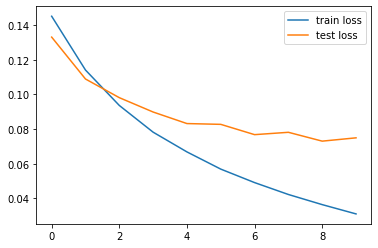

In [21]:
# Plot the train & test losses

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [27]:
# Calculate the train & test 

correct_train = 0
all_train = 0

for inputs, targets in train_loader:
    inputs = inputs.to(device) 
    targets = targets.to(device)

    inputs = inputs.view(-1, 784) # we reshape the inputs
    
    outputs = model(inputs)

    _, predictions = torch.max(outputs, 1) # returns the max and argmax

    correct_train += (predictions == targets).sum().item()
    all_train += targets.shape[0]

training_accuracy = correct_train / all_train

correct_test = 0
all_test = 0

test_loss = []
for inputs, targets in test_loader:
    inputs = inputs.to(device) 
    targets = targets.to(device)

    inputs = inputs.view(-1, 784) # we reshape the inputs
    
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1) # returns the max and argmax

    correct_test += (predictions == targets).sum().item()
    all_test += targets.shape[0]

testing_accuracy = correct_test / all_test

print('Accuracy for Train = {}, Test = {}'.format(training_accuracy, testing_accuracy))

Accuracy for Train = 0.9937833333333334, Test = 0.977


In [0]:
# Calculate and Plot the Confusion Matrix

def plot_confusion_matrix(confusion_matrix, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Conf Matrix Function
    This function prints the confusion matrix
    Args:...
    """

    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusionmatrix.sum(axis=1)[:, np.newaxis]
        print('Confusion Matrix Normalised!')
    else:
        print('Confusion Matrix has not been normalised...')

    print(confusion_matrix)

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    frmt = '.2f' if normalize else 'd'
    threshold = confusion_matrix.max() / 2.0
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i,j], frmt), horizontalalignment="center", color="white" if confusion_matrix[i,j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

Confusion Matrix has not been normalised...
[[ 968    0    3    2    0    1    3    1    2    0]
 [   0 1120    4    0    0    1    2    1    7    0]
 [   5    1 1011    2    1    0    2    2    8    0]
 [   0    0    9  984    0    1    1    3    8    4]
 [   0    0    5    0  960    1    7    3    1    5]
 [   2    0    0   15    1  858    3    2    8    3]
 [   5    3    1    1    1    2  942    0    3    0]
 [   0    3   11    2    0    0    0 1004    2    6]
 [   4    0    5    3    3    5    1    3  948    2]
 [   2    2    0    5   12    1    0    6    6  975]]


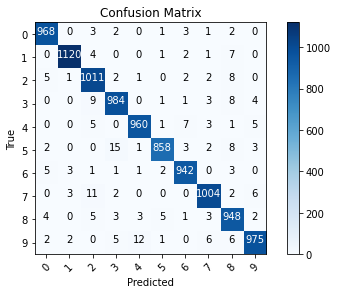

In [32]:
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    inputs = inputs.to(device) 
    targets = targets.to(device)

    inputs = inputs.view(-1, 784) # we reshape the inputs
    
    outputs = model(inputs)

    _, predictions = torch.max(outputs, 1) # returns the max and argmax

    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

Text(0.5, 1.0, 'True Label: 9, Predicted: 4')

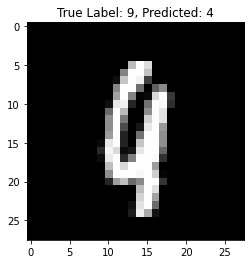

In [38]:
# Display missclassified examples

missclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(missclassified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title('True Label: {}, Predicted: {}'.format(y_test[i], int(p_test[i])))